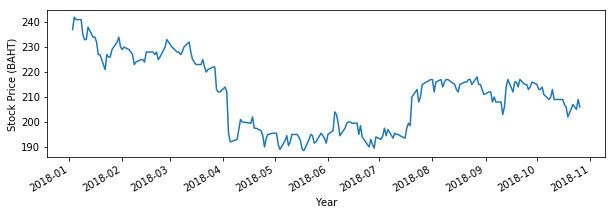

202


In [34]:
#This Section Is For ARIMA and ARIMAX
import pandas as pd
from pandas import Series
import numpy as np
import datetime
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn
from fbprophet import Prophet
import statsmodels.api as sm
import statsmodels.tsa as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib import pyplot
import itertools as it
from matplotlib import mlab

kbank = pdr.get_data_yahoo("KBANK.BK", start="2018-01-01", end="2018-10-25")
kbank= kbank.dropna()
close_price = kbank['Close'].get_values()
date = kbank.index
kbank.Close.plot(figsize=(10,3))
plt.ylabel('Stock Price (BAHT)')
plt.xlabel('Year')
plt.show()
print(len(close_price))

#Find RMSE from Residual Error
def RMSEfromResid(X):
    summ = 0
    for i in X:
        summ+=i**2
    return((summ/len(X))**0.5)

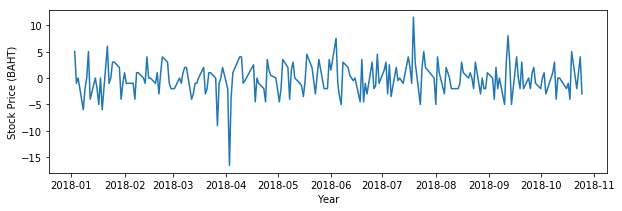

In [14]:
# create a differenced series
plt.figure(figsize=(10,3))
plt.plot(date[:len(date)-1], kbank['Close'].diff().dropna())
plt.ylabel('Stock Price (BAHT)')
plt.xlabel('Year')
plt.show()

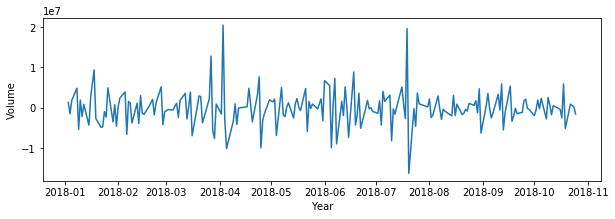

In [15]:
# create a differenced series
plt.figure(figsize=(10,3))
plt.plot(date[:len(date)-1], kbank['Volume'].diff().dropna())
plt.ylabel('Volume')
plt.xlabel('Year')
plt.show()

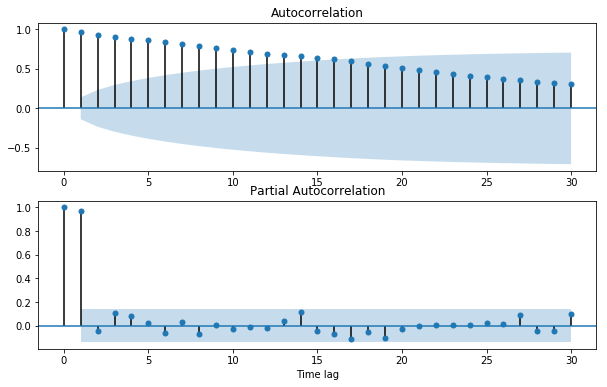

In [16]:
#Analysis of ACF and PACF on Close Price
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(kbank['Close'], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(kbank['Close'], lags=30, ax=ax2)
plt.xlabel('Time lag')
plt.show()

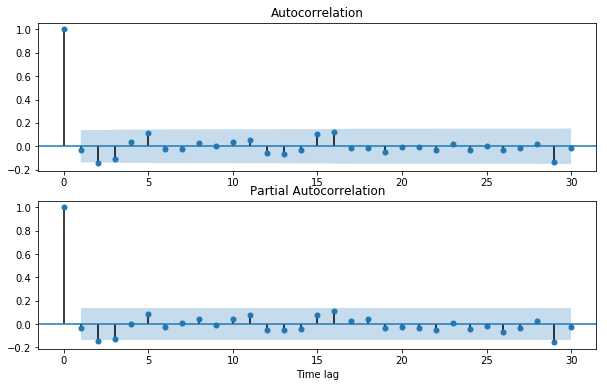

In [17]:
#Analysis of ACF and PACF on differece Close Price
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(kbank['Close'].diff().dropna(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(kbank['Close'].diff().dropna(), lags=30, ax=ax2)
plt.xlabel('Time lag')
plt.show()

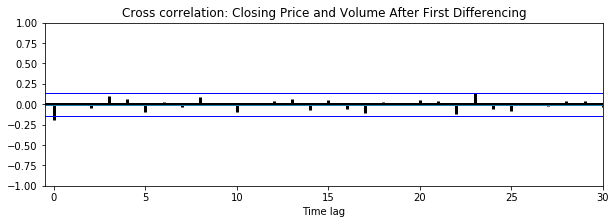

In [18]:
#Cross Correlation between differenced closing price and differenced volume
xaxis = [x for x in range(-30,31)]
y_up = [(2/(len(close_price)**0.5)) for i in range(-30,31)]
y_down = [(-2/(len(close_price)**0.5)) for i in range(-30,31)]
close_diff = kbank['Close'].diff().dropna().get_values()
vol_diff =  kbank['Volume'].diff().dropna().get_values()

fig = plt.figure(figsize=(10,3))
plt.xcorr(close_diff, vol_diff, usevlines=True, maxlags=30, normed=True, lw=3)
plt.ylim(-1, 1)
plt.xlim(-0.5, 30)
plt.axhline(0, color='black', lw=2)
plt.plot(xaxis, y_up, color='blue', lw=1)
plt.plot(xaxis, y_down, color='blue', lw=1)
plt.xlabel('Time lag')
plt.title('Cross correlation: Closing Price and Volume After First Differencing')
plt.show()

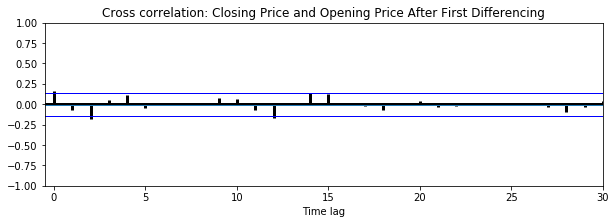

In [19]:
#Cross Correlation between differenced closing price and differenced opening price 
open_diff =  kbank['Open'].diff().dropna().get_values()

fig = plt.figure(figsize=(10,3))
plt.xcorr(close_diff,open_diff, usevlines=True, maxlags=30, normed=True, lw=3)
plt.ylim(-1, 1)
plt.xlim(-0.5, 30)
plt.axhline(0, color='black', lw=2)
plt.plot(xaxis, y_up, color='blue', lw=1)
plt.plot(xaxis, y_down, color='blue', lw=1)
plt.xlabel('Time lag')
plt.title('Cross correlation: Closing Price and Opening Price After First Differencing')
plt.show()

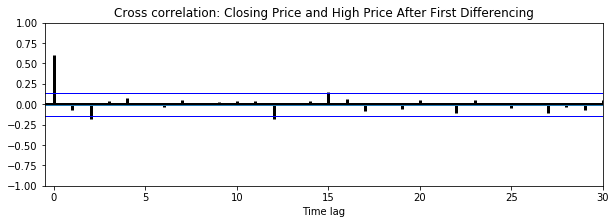

In [20]:
#Cross Correlation between differenced closing price and differenced high price 
high_diff =  kbank['High'].diff().dropna().get_values()

fig = plt.figure(figsize=(10,3))

plt.xcorr(close_diff, high_diff,usevlines=True, maxlags=30, normed=True, lw=3)

plt.ylim(-1, 1)
plt.xlim(-0.5, 30)
plt.axhline(0, color='black', lw=2)
plt.plot(xaxis, y_up, color='blue', lw=1)
plt.plot(xaxis, y_down, color='blue', lw=1)
plt.xlabel('Time lag')
plt.title('Cross correlation: Closing Price and High Price After First Differencing')
plt.show()

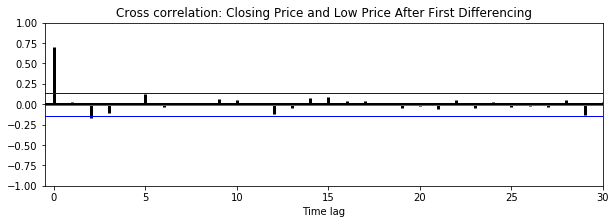

In [21]:
#Cross Correlation between differenced closing price and differenced low price
low_diff =  kbank['Low'].diff().dropna().get_values()

fig = plt.figure(figsize=(10,3))

plt.xcorr(close_diff,low_diff,usevlines=True, maxlags=30, normed=True, lw=3)

plt.ylim(-1, 1)
plt.xlim(-0.5, 30)
plt.axhline(0, color='black', lw=2)
plt.plot(xaxis, y_up, color='blue', lw=1)
plt.plot(xaxis, y_down, color='blue', lw=1)
plt.xlabel('Time lag')
plt.title('Cross correlation: Closing Price and Low Price After First Differencing')
plt.show()

In [22]:
#ARIMA Models selection
kbank = pdr.get_data_yahoo("KBANK.BK", start="2018-01-01", end="2018-10-25")
date = kbank.index
X = kbank['Close'].get_values()
size = int(len(X)*0.80)
train, test = X[0:size], X[size:len(X)]
date_test = date[size:]
def evaluate_arima_model(X, model_order):
    model_arima = ARIMA(X, order=model_order).fit(disp=0)
    AIC = ARIMAResults.aic(model_arima)
    BIC = ARIMAResults.bic(model_arima)
    LLF = model_arima.llf
    RMSE = RMSEfromResid(model_arima.resid)
    return([AIC, BIC, LLF, RMSE])

import warnings
warnings.filterwarnings("ignore")
# evaluate combinations of p, d and q values for an ARIMA model
p_values = [0,1,2,3]
d_values = [1]
q_values = [0,1,2]
data = list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                [AIC, BIC, LLF, RMSE] = evaluate_arima_model(train, order)
                data.append([order,AIC, BIC, LLF, RMSE])
            except:
                continue

ARIMA_Models = pd.DataFrame(data,columns=['ARIMA', 'AIC', 'BIC', 'Maximum Log-Likelihood', 'RMSE'],dtype=float)

In [23]:
test

array([215., 213., 211., 212., 212., 208., 210., 208., 208., 203., 206.,
       214., 217., 212., 216., 216., 214., 217., 215., 215., 213., 214.,
       216., 215., 213., 213., 214., 211., 209., 210., 213., 209., 209.,
       209., 207., 206., 202., 207., 205., 209., 206.])

Test RMSE: 2.808


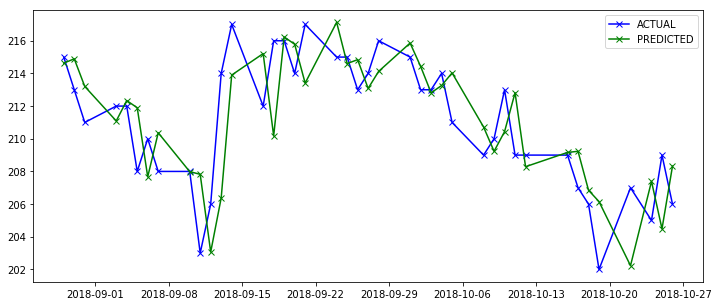

In [24]:
#ARIMA
#This Section is for Prediction

history = [x for x in train]
predictions = list()
data=list()
#len_test = len(test)
len_test= len(test)
for t in range(len_test):
    model_arima = ARIMA(endog = history, order=(3, 1, 0)).fit(disp=0)
    output = model_arima.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    data.append([date_test[t], obs, yhat])
    
RMSE = (mean_squared_error(test, predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'],dtype=float)
print('Test RMSE: %.3f' % RMSE)
# plot
pyplot.rcParams['figure.figsize'] = (12,5)
pyplot.plot(date_test, test, color='Blue', label='ACTUAL', marker='x')
pyplot.plot(date_test, predictions, color='green', label='PREDICTED', marker='x')
pyplot.legend(loc='upper right')
pyplot.show()
arima_pred = predictions
arima_RMSE = RMSE

In [25]:
#ARIMAX Model
kbank2 = pdr.get_data_yahoo("KBANK.BK", start="2017-12-27", end="2018-10-25")
kbank2= kbank2.dropna()
kbank2['open_lag1'] = kbank2['Open'].diff().shift()
kbank2['open_lag2'] = kbank2['Open'].diff().shift().shift()
kbank2['high_lag1'] = kbank2['High'].diff().shift()
kbank2['high_lag2'] = kbank2['High'].diff().shift().shift()
kbank2['low_lag1'] = kbank2['Low'].diff().shift()
kbank2['low_lag2'] = kbank2['Low'].diff().shift().shift()
kbank2.dropna(inplace=True)
date = kbank2.index
print(len(kbank2))

202


In [26]:
#ARIMAX Model Selection
close = kbank2['Close']
ex = kbank2[['open_lag2', 'high_lag2']]
m = len(close)
size = int(len(X)*0.8)
train, test = close[0:size], close[size:m]
ex_train, ex_test = ex[0:size], ex[size:m]
date_test = date[size:]

def evaluate_arimax_model(y, X, model_order):
    model_arimax = ARIMA(endog = y, exog=X, order=model_order).fit()
    AIC = ARIMAResults.aic(model_arimax)
    BIC = ARIMAResults.bic(model_arimax)
    LLF = model_arimax.llf
    RMSE = RMSEfromResid(model_arimax.resid)
    return([AIC, BIC, LLF, RMSE])

import warnings
warnings.filterwarnings("ignore")
# evaluate combinations of p, d and q values for an ARIMA model
p_values = [0,1,2,3]
d_values = [1]
q_values = [0,1,2]
data = list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                [AIC, BIC, LLF, RMSE] = evaluate_arimax_model(train,ex_train , order)
                data.append([order,AIC, BIC, LLF, RMSE])
            except:
                continue

ARIMAX_Models = pd.DataFrame(data,columns=['ARIMAX', 'AIC', 'BIC', 'Maximum Log-Likelihood', 'RMSE'],dtype=float)

In [31]:
ex

,open_lag2,high_lag2
Date,,
2018-01-03,-1.0,-1.0
2018-01-04,1.0,1.0
2018-01-05,-1.0,1.0
2018-01-08,5.0,7.0
2018-01-09,3.0,0.0
2018-01-10,1.0,1.0
2018-01-11,-3.0,-5.0
2018-01-12,-5.0,-4.0
2018-01-15,-2.0,-3.0


Test RMSE: 2.784


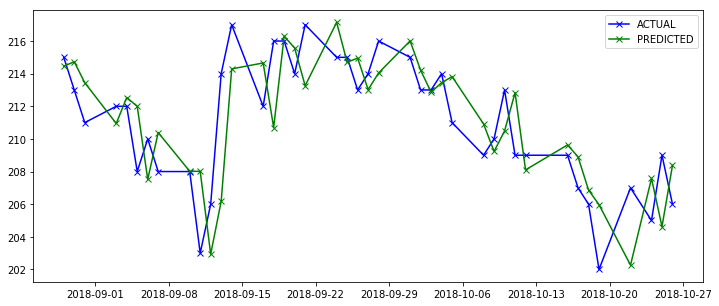

In [28]:
#ARIMAX
#This Section is for Prediction

history = [x for x in train]
his_u = ex_train
predictions = list()
data=list()
test_index = list()
for t in range(len(ex_test)):
    model_arimax = ARIMA(endog = history,exog=his_u, order=(2, 1, 0)).fit(disp=0)
    output = model_arimax.forecast(steps=1, exog=ex_test[['open_lag2', 'high_lag2']].iloc[[t]])
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    test_index.append(t)
    his_u = ex_train.append(ex_test.iloc[test_index])
    data.append([date_test[t], test[t], yhat])
    
RMSE = (mean_squared_error(test, predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'],dtype=float)
print('Test RMSE: %.3f' % RMSE)
# plot
pyplot.rcParams['figure.figsize'] = (12,5)
pyplot.plot(date_test, test, color='Blue', label='ACTUAL', marker='x')
pyplot.plot(date_test, predictions, color='green', label='PREDICTED', marker='x')
pyplot.legend(loc='upper right')
pyplot.show()
arimax_pred = predictions
arimax_RMSE = RMSE

In [17]:
#This section is for ANN Model 1 and ANN Model 2
kbank3 = pdr.get_data_yahoo("KBANK.BK", start="2008-01-01", end="2018-10-25")
kbank3= kbank3.dropna()
close_lag1 = list(kbank3['Close'].shift().dropna())
close_lag2 = list(kbank3['Close'].shift().shift().dropna())
open_lag1 = list(kbank3['Open'].shift().dropna())
open_lag2 = list(kbank3['Open'].shift().shift().dropna())
high_lag1 = list(kbank3['High'].shift().dropna())
high_lag2 = list(kbank3['High'].shift().shift().dropna())
low_lag1 = list(kbank3['Low'].shift().dropna())
low_lag2 = list(kbank3['Low'].shift().shift().dropna())
date3 = kbank3.index

In [18]:
#ANN Model 1
m = len(close_lag2)
lag = 2
n = 1
X = np.zeros((m,n*lag))
y =kbank3['Close'].get_values()[lag:]
for i in range(len(close_lag2)):
    X[i,0] = close_lag1[i+1]
    X[i,1] = close_lag2[i]

#Choose ANN test set to be the same as the test set of ARIMA
size = int(len(kbank3)*0.984)
X_train, X_test = X[0:size], X[size:len(X)]
y_train, y_test = y[0:size], y[size:len(X)]
date_test = date3[size+lag:]
RMSE_list = list()
node = list()
node_rmse = list()
for num_node in range(2,400,8):
    mlp = MLPRegressor(hidden_layer_sizes=(num_node,), random_state=0, max_iter=2000)
    ann_model = mlp.fit(X_train, y_train)
    y_pred_train = mlp.predict(X_train)
    RMSE = (mean_squared_error(y_train, y_pred_train))**0.5
    node_rmse.append(RMSE)
    node.append(num_node)
best_node1 = node[np.argmin(node_rmse)]
print(best_node1)
print(node_rmse)

42
[2.870449461698269, 3.0133070313458807, 2.9216987886151298, 2.773425579527928, 2.8227092005289713, 2.7355725384430656, 2.762525777971472, 2.9385138000455227, 2.983016087700121, 3.1668967082001296, 3.009760646278588, 3.2310898726047848, 3.365519480953901, 3.1862860406530555, 3.1169957013675194, 3.1145252858779036, 3.141514050873028, 3.1318632267037096, 3.1371639306756443, 3.2599017608884284, 2.9588863066867725, 3.06210407052423, 3.1455546141003903, 3.2025110444782308, 3.246498314699383, 3.0222939254072365, 3.0178725314069785, 3.1182693711579783, 3.168449487058484, 3.0517384940813623, 3.274448121718971, 3.1315308556093115, 2.9837985626928187, 3.0719389218977473, 3.2193784492897386, 2.9965692727965894, 3.1483387405374788, 3.106739264897779, 3.170929111771865, 3.106959203159585, 3.1592015116965793, 2.9578039056868866, 3.0974506567267985, 3.0764042004610053, 3.107041634185645, 3.152450216895818, 3.164490401007375, 3.2184616313159444, 3.1145116877091783, 2.9759700122082364]


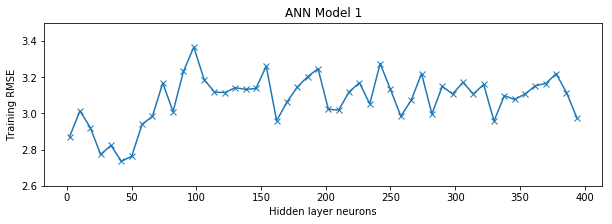

In [19]:
plt.figure(figsize=(10,3))
plt.plot(node, node_rmse, marker='x')
plt.ylabel('Training RMSE')
plt.xlabel('Hidden layer neurons')
plt.title('ANN Model 1')
plt.ylim(2.6, 3.5)
plt.show()

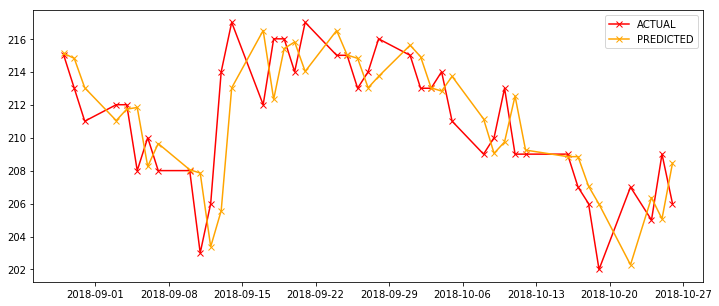

Test RMSE: 2.756


In [20]:
mlp = MLPRegressor(hidden_layer_sizes=(best_node1,), random_state=0,max_iter=2000)
ann_model = mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
pyplot.rcParams['figure.figsize'] = (12,5)
pyplot.plot(date_test, y_test, color='Red', label='ACTUAL', marker='x')
pyplot.plot(date_test, y_pred, color='Orange', label='PREDICTED', marker='x')
pyplot.legend(loc='upper right')
pyplot.show()
print('Test RMSE: %.3f' % RMSE)
ann1_pred = y_pred
ann1_RMSE = RMSE

In [21]:
#ANN Model 2
m = len(close_lag2)
lag = 2
n = 4
X = np.zeros((m,n*lag))
y =kbank3['Close'].get_values()[lag:]
for i in range(m):
    X[i,0] = close_lag1[i+1]
    X[i,1] = close_lag2[i]
    X[i,2] = open_lag1[i+1]
    X[i,3] = open_lag2[i]
    X[i,4] = high_lag1[i+1]
    X[i,5] = high_lag2[i]
    X[i,6] = low_lag1[i+1]
    X[i,7] = low_lag2[i]

#Choose ANN test set to be the same as the test set of ARIMA
size = int(len(kbank3)*0.984)
X_train, X_test = X[0:size], X[size:len(X)]
y_train, y_test = y[0:size], y[size:len(X)]
date_test = date3[size+lag:]
RMSE_list = list()
node = list()
node_rmse = list()
for num_node in range(8,200,2):
    mlp = MLPRegressor(hidden_layer_sizes=(num_node,), random_state=456, max_iter=10000, learning_rate='adaptive')
    ann_model = mlp.fit(X_train, y_train)
    y_pred_train = mlp.predict(X_train)
    RMSE = (mean_squared_error(y_train, y_pred_train))**0.5
    node_rmse.append(RMSE)
    node.append(num_node)
best_node2 = node[np.argmin(node_rmse)]
print(node_rmse)
print(best_node2)

[3.176190268077974, 3.55379105733384, 3.6164201382032735, 2.888563066862733, 3.2113548283523654, 3.2266410966290597, 3.100411988783533, 4.275435344849052, 3.3959780058246336, 3.8848166042765064, 3.1505171605416993, 4.256300630767773, 3.377084457431171, 3.1393140483961393, 3.137519863563841, 4.005329720254769, 3.435016815879698, 3.885156012080387, 3.4564936209836303, 3.6912349260729242, 3.6834212617772377, 3.0470816816219974, 3.1298360733251145, 3.1939182577257372, 3.130997820094692, 3.228848577816747, 3.0716270557094885, 3.1885172050155943, 3.0503626529857994, 3.210258730850722, 3.018437768626942, 3.3776209858315713, 3.270611389272552, 3.0408010275025465, 3.0555715531539644, 3.6832170282534165, 3.2509464245372848, 3.153189548695993, 3.193223173096678, 3.293488377335044, 3.305779179128809, 3.3339450734769764, 3.994485770178788, 3.7723581178264913, 3.374030836253181, 3.1760286592785976, 3.5735230114594136, 3.3820130981392333, 3.0358013066877536, 3.1421057488882735, 3.158856742990017, 3.6

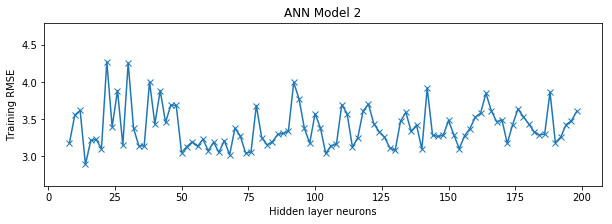

In [22]:
plt.figure(figsize=(10,3))
plt.plot(node, node_rmse, marker='x')
plt.ylabel('Training RMSE')
plt.xlabel('Hidden layer neurons')
plt.ylim(2.6, 4.8)
plt.title('ANN Model 2')
plt.show()

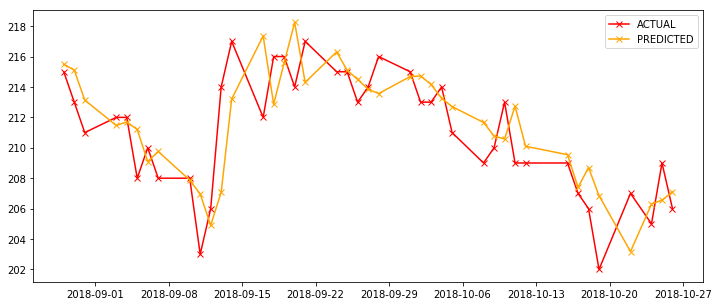

Test RMSE: 2.559


In [23]:
mlp = MLPRegressor(hidden_layer_sizes=(best_node2,), random_state=456,max_iter=10000, learning_rate='adaptive')
ann_model = mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
pyplot.rcParams['figure.figsize'] = (12,5)
pyplot.plot(date_test, y_test, color='Red', label='ACTUAL', marker='x')
pyplot.plot(date_test, y_pred, color='Orange', label='PREDICTED', marker='x')
pyplot.legend(loc='upper right')
pyplot.show()
print('Test RMSE: %.3f' % RMSE)
ann2_pred = y_pred
ann2_RMSE = RMSE

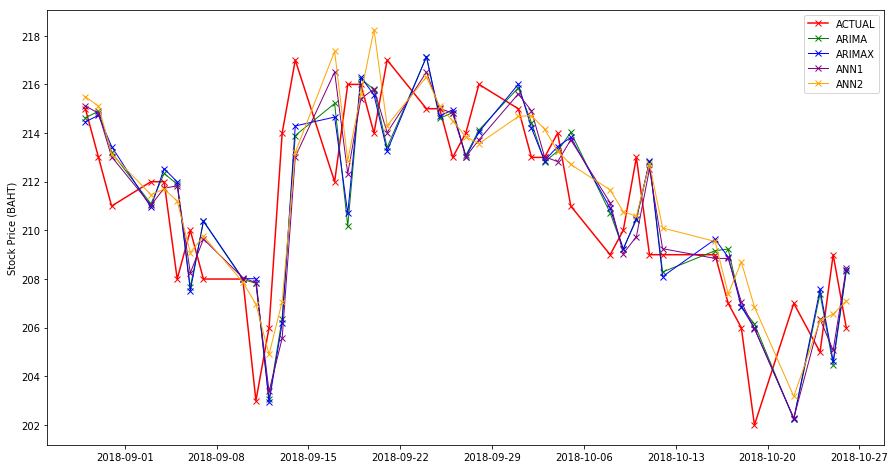

ARIMA Test RMSE: 2.808
ARIMAX Test RMSE: 2.784
ANN Model 1 Test RMSE: 2.756
ANN Model 2 Test RMSE: 2.559


In [24]:
#Compare all models with RMSE on test set and graphical representation
pyplot.rcParams['figure.figsize'] = (15,8)
pyplot.plot(date_test, test, color='red', label='ACTUAL', marker='x')
pyplot.plot(date_test, arima_pred, color='green', label='ARIMA', marker='x', lw=1)
pyplot.plot(date_test, arimax_pred, color='blue', label='ARIMAX', marker='x', lw=1)
pyplot.plot(date_test, ann1_pred, color='purple', label='ANN1', marker='x', lw=1)
pyplot.plot(date_test, ann2_pred, color='orange', label='ANN2', marker='x', lw=1)
pyplot.legend(loc='upper right')
plt.ylabel('Stock Price (BAHT)')
pyplot.show()
print('ARIMA Test RMSE: %.3f' % arima_RMSE)
print('ARIMAX Test RMSE: %.3f' % arimax_RMSE)
print('ANN Model 1 Test RMSE: %.3f' % ann1_RMSE)
print('ANN Model 2 Test RMSE: %.3f' % ann2_RMSE)

In [27]:
writer = pd.ExcelWriter('train.xlsx')
kbank3.to_excel(writer,'Sheet1')
writer.save()

In [29]:
len(kbank3)

2646